# SIIM-ACR DICOM Study Dataset

In [1]:
#@title Download SIIM-ACR Dataset
#@markdown Fill in the login information to access the S3 bucket.

aws_access_key_id = ''  #@param {type: "string"}
aws_secret_access_key = '' #@param {type: "string"}

import os
import boto3
import zipfile
import shutil

# place the login information for accessing the S3 bucket
s3r = boto3.resource('s3', aws_access_key_id=aws_access_key_id, aws_secret_access_key=aws_secret_access_key)
bucket = s3r.Bucket('pneumothorax-siim-acr-scans')

os.mkdir('siim-acr-data')

# fetch the still imbalanced eyeball dataset
bucket.download_file('train-rle.csv', 'siim-acr-data/train-rle.csv')
bucket.download_file('learn-pneumonia/pneumothorax-trainset.zip', 'siim-acr-data/pneumothorax-trainset.zip')

# see DICOM folder datset for an overview of the unzipped directory structure
zipfile.ZipFile('siim-acr-data/pneumothorax-trainset.zip', 'r').extractall('siim-acr-data/train-pneumothorax')
os.remove('siim-acr-data/pneumothorax-trainset.zip')

# delete hidden archive folder
shutil.rmtree('siim-acr-data/train-pneumothorax/__MACOSX')

In [2]:
%%capture
!pip install pydicom

# Exploratory Data Analysis (EDA)


In [3]:
import glob
import pydicom as dicom

studies = [dicom.dcmread(instance, defer_size="512 MB") for instance in glob.glob('siim-acr-data/train-pneumothorax/**/**/*.dcm', recursive=True)]

In [4]:
import pandas as pd

labels = pd.read_csv('siim-acr-data/train-rle.csv', index_col='ImageId')

## Patient Stratification and Balance

In [6]:
import seaborn as sns
sns.set_style('whitegrid')

In [37]:
# The exact same CT scan is found three times in this dataset
id='ce87b1cb-e06c-4d10-a016-67bebb00f47d'
patient = [p for p in studies if p.PatientID==id][0]

In [24]:
#@title Patient Information { run: "auto" }
def show_dcm_info(dataset):
    pat_name = dataset.PatientName
    display_name = pat_name.family_name + ", " + pat_name.given_name
    print("Patient's name......:", display_name)
    print("Patient id..........:", dataset.PatientID)
    print("Patient's Age.......:", dataset.PatientAge)
    print("Patient's Sex.......:", dataset.PatientSex)
    print("Modality............:", dataset.Modality)
    print("Body Part Examined..:", dataset.BodyPartExamined)
    print("View Position.......:", dataset.ViewPosition)
    
    if 'PixelData' in dataset:
        rows = int(dataset.Rows)
        cols = int(dataset.Columns)
        print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
            rows=rows, cols=cols, size=len(dataset.PixelData)))
        if 'PixelSpacing' in dataset:
            print("Pixel spacing....:", dataset.PixelSpacing)

The scans provided in the SIIM-ACR Dataset may be all from different machines, but aren't normalized. Due to the missing rescale slope their intensity cannot be converted to Hounsfield Units (HU).

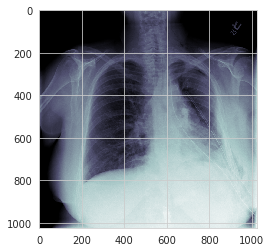

Patient's name......: ce87b1cb-e06c-4d10-a016-67bebb00f47d, 
Patient id..........: ce87b1cb-e06c-4d10-a016-67bebb00f47d
Patient's Age.......: 61
Patient's Sex.......: F
Modality............: CR
Body Part Examined..: CHEST
View Position.......: PA
Image size.......: 1024 x 1024, 135760 bytes
Pixel spacing....: [0.14300000000000002, 0.14300000000000002]


In [38]:
import matplotlib.pyplot as plt

# process the patient's study to view the image and metadata
plt.imshow(patient.pixel_array, cmap=plt.cm.bone, interpolation='none')
plt.show()
show_dcm_info(patient)

### Ground-Truth Table

In [7]:
# segmentation masks for some of the inspected labelings were similar
labels = labels.loc[~labels.index.duplicated(keep='first')]

In [8]:
import pandas as pd

batch = []

for p in studies:
  if p.SOPInstanceUID in labels.index:
    # load metadata from study
    row = {
        'sop_instance_uid' : p.SOPInstanceUID,
        'mask_rle' : labels.loc[p.SOPInstanceUID][' EncodedPixels'],
        'patient_id' : p.PatientID,
        'sex' : p.PatientSex,
        'age' : int(p.PatientAge)
    }
    batch.append(row)

# abnormal age values are sorted out already
ground_truth = pd.DataFrame(batch)

# create a target column with the study result
ground_truth.loc[ground_truth['mask_rle'] == '-1', 'diagnosis'] = 'N'
ground_truth.loc[ground_truth['mask_rle'] != '-1', 'diagnosis'] = 'P'

In [9]:
ground_truth.drop_duplicates(subset='sop_instance_uid', keep = 'first', inplace = True) 

In [22]:

ground_truth.sort_values(by=['age','patient_id'])

,sop_instance_uid,mask_rle,patient_id,sex,age,diagnosis
1233,1.2.276.0.7230010.3.1.4.8323329.3766.151787517...,-1,e91bd8d2-5161-4fa5-bb29-d621c7c632f4,F,1,N
342,1.2.276.0.7230010.3.1.4.8323329.31878.15178751...,-1,0bdc7d97-4ccb-4ad8-8277-192b2ef4c8af,F,2,N
2311,1.2.276.0.7230010.3.1.4.8323329.5885.151787519...,-1,1d8e7da6-d613-47ec-84db-9cf25e96a561,M,2,N
4882,1.2.276.0.7230010.3.1.4.8323329.12000.15178752...,-1,3c1a395a-585c-4369-b874-f6ea1b177635,F,2,N
3403,1.2.276.0.7230010.3.1.4.8323329.5750.151787519...,-1,4115481e-f121-49d2-af16-ee6c9edbda8b,F,2,N
...,...,...,...,...,...,...
1014,1.2.276.0.7230010.3.1.4.8323329.7030.151787520...,-1,0cd34056-7a1a-4f54-b70c-4e3c874b5fc0,F,89,N
9511,1.2.276.0.7230010.3.1.4.8323329.6990.151787520...,-1,2a154024-2498-4a94-980e-3e45b7da00cf,M,89,N
8564,1.2.276.0.7230010.3.1.4.8323329.10166.15178752...,-1,38de65ca-7788-4651-b497-edf96947f9f2,M,94,N
1661,1.2.276.0.7230010.3.1.4.8323329.4830.151787518...,-1,771944af-1b29-4566-aa94-653fc37980c7,M,148,N


In [27]:
# the age in two cases seems unrealisitc
ground_truth = ground_truth[ground_truth['age']<100]

### Undersampling: Age and Sex

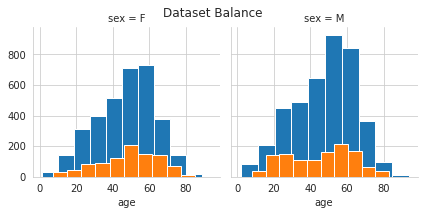

In [28]:
g = sns.FacetGrid(ground_truth, col='sex', hue='diagnosis')
g.fig.suptitle('Dataset Balance')
g.map(plt.hist, 'age');

In [29]:
positives = ground_truth[ground_truth['diagnosis'] == 'P']
negatives = ground_truth[ground_truth['diagnosis'] == 'N']

In [30]:
# undersample negative datapoints
dataset = pd.concat([positives, negatives.sample(n=len(positives))])
print('Total Datapoints available after Undersampling:',len(dataset))

Total Datapoints available after Undersampling: 4280


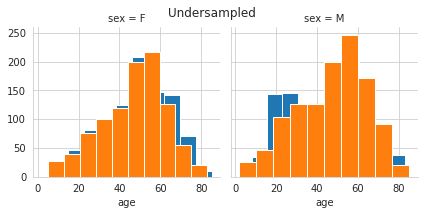

In [31]:
g = sns.FacetGrid(dataset, col='sex', hue='diagnosis')
g.fig.suptitle('Undersampled')
g.map(plt.hist, 'age');

There is now an imbalance for male patients from the age of 0 to 30.

## Labelling: Segmentation Mask

In [32]:
#@title Run-length encoding
import numpy as np

def mask2rle(img, width, height):
    rle = []
    lastColor = 0;
    currentPixel = 0;
    runStart = -1;
    runLength = 0;

    for x in range(width):
        for y in range(height):
            currentColor = img[x][y]
            if currentColor != lastColor:
                if currentColor == 255:
                    runStart = currentPixel;
                    runLength = 1;
                else:
                    rle.append(str(runStart));
                    rle.append(str(runLength));
                    runStart = -1;
                    runLength = 0;
                    currentPixel = 0;
            elif runStart > -1:
                runLength += 1
            lastColor = currentColor;
            currentPixel+=1;

    return " ".join(rle)

def rle2mask(rle, width, height):
    if rle == '-1':
        return np.zeros(width* height).reshape((width, height))
    mask= np.zeros(width* height)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        current_position += start
        mask[current_position:current_position+lengths[index]] = 255
        current_position += lengths[index]

    return mask.reshape(width, height)

def rle2label(rle):
    return np.float32(1) if rle != '-1' else np.float32(0)

In [40]:
# decode mask from rle encoded training labels
mask = rle2mask(labels.loc[patient.SOPInstanceUID][' EncodedPixels'], 1024, 1024)

# apply mask to image
scan = np.ma.masked_where(mask==0, patient.pixel_array, copy=True)

# axis are swapped
scan = np.transpose(scan)

### Bounding Box Generation

In [41]:
from scipy import ndimage

measurements = []

# generate bounding boxes from the segmentation mask
objs = ndimage.find_objects(~scan.mask)

for ob in objs:
    measurements.append(((objs[0][1].start, objs[0][0].start), int(ob[1].stop - ob[1].start), (int(ob[0].stop - ob[0].start))))

In [42]:
measurements

[((619, 224), 187, 90)]

### Inspect: Patient's Diagnosis

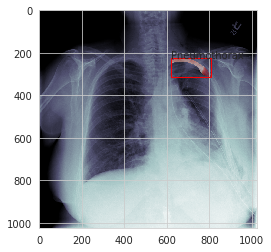

In [43]:
import matplotlib.patches as patches

fig,ax = plt.subplots(1)

# view CT scan
ax.imshow(patient.pixel_array, cmap=plt.cm.bone, interpolation='none')

# mark the space labeled with pneumothorax in red
ax.imshow(scan, cmap='Reds', alpha=0.5, interpolation='none')

# draw multiple possible bounding boxes
for bbox in measurements:
    rect = patches.Rectangle(bbox[0],bbox[1],bbox[2],linewidth=1,edgecolor='r',facecolor='none')
    plt.text(bbox[0][0],bbox[0][1],'Pneumothorax')
    ax.add_patch(rect)

plt.show()

# Prepare Pneumothorax Dataset

## Labelling: Add Bounding Boxes

In [44]:
from scipy import ndimage

bbox_target = []

# shuffle undersampled dataset
pneumothorax = dataset.sample(frac=1).reset_index(drop=True)

for i, datapoint in pneumothorax.iterrows():
  if datapoint['diagnosis']=='P':
    bbox = []

    # decode mask from rle encoding
    mask = rle2mask(datapoint['mask_rle'], 1024, 1024)

    # apply mask to image
    scan = np.ma.masked_where(mask==0, patient.pixel_array, copy=True)

    # axis are swapped
    scan = np.transpose(scan)

    # generate bounding boxes from the segmentation mask
    objs = ndimage.find_objects(~scan.mask)

    for ob in objs:
        # reactangle with upper left corner point
        x = objs[0][1].start
        y = objs[0][0].start
        w = ob[1].stop - ob[1].start
        h = ob[0].stop - ob[0].start

        # move to the center of the region
        x = int(x + w/2)
        y = int(y + h/2)

        bbox.append((x,y,w,h))

    bbox_target.append(bbox[0])

  else:
    bbox_target.append('-1')

pneumothorax['bbox'] = bbox_target

In [45]:
pneumothorax.sort_values(by=['age'])

,sop_instance_uid,mask_rle,patient_id,sex,age,diagnosis,bbox
1195,1.2.276.0.7230010.3.1.4.8323329.5885.151787519...,-1,1d8e7da6-d613-47ec-84db-9cf25e96a561,M,2,N,-1
418,1.2.276.0.7230010.3.1.4.8323329.4671.151787518...,-1,469d175a-eed2-4809-9e49-e05027602eca,M,3,N,-1
4025,1.2.276.0.7230010.3.1.4.8323329.12757.15178752...,-1,4fa887a9-b3fc-4c78-8395-77ad7f7207a5,M,4,N,-1
891,1.2.276.0.7230010.3.1.4.8323329.32267.15178751...,-1,7918b6ec-919c-421c-80a3-d027e436a140,F,5,N,-1
1150,1.2.276.0.7230010.3.1.4.8323329.10835.15178752...,-1,f7b86083-d303-4110-8a3b-59509b4055b4,M,5,N,-1
...,...,...,...,...,...,...,...
3144,1.2.276.0.7230010.3.1.4.8323329.4692.151787518...,266422 6 1015 11 1011 15 1007 18 1004 21 1002 ...,dfb42cef-4a72-472a-82e6-ea21c0a2a65e,M,83,P,"(344, 156, 169, 85)"
1811,1.2.276.0.7230010.3.1.4.8323329.13780.15178752...,310556 19 999 26 996 29 992 32 989 36 986 38 9...,c6daf044-23d2-4535-bd25-6432b7d8498b,M,83,P,"(405, 216, 205, 193)"
1011,1.2.276.0.7230010.3.1.4.8323329.14046.15178752...,-1,20ed641b-3e1a-46d7-8b3c-494fbe84a4a9,M,84,N,-1
3241,1.2.276.0.7230010.3.1.4.8323329.11315.15178752...,574685 12 1007 19 1001 25 997 27 995 29 994 30...,96f681e1-26b1-4896-b69c-f28788b1db0e,F,85,P,"(656, 227, 191, 90)"


## Export Ground-Truth Table

In [46]:
# write to disk
pneumothorax.to_csv('siim-acr-data/train.csv', index=False)

In [47]:
# export ground-truth to S3
bucket.upload_file('siim-acr-data/train.csv', 'train.csv')